In [110]:
# setup e carga da base

import pandas as pd
import numpy as np

# url pública do csv
url = "https://raw.githubusercontent.com/cassiusf/datasets/main/diamonds.csv"

# carga
df_raw = pd.read_csv(url)

# cópia de trabalho
df_clean = df_raw.copy()

# checagens rápidas de integridade
expected_cols = {'price','carat','color','clarity','x','y','z','depth','table','cut'}
assert expected_cols.issubset(set(df_clean.columns)), "colunas inesperadas na base"

# tipos básicos
cat_cols = ['color','clarity','cut']
for c in cat_cols:
    df_clean[c] = df_clean[c].astype('category')

num_cols = ['price','carat','x','y','z','depth','table']
for c in num_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

# verificação de nulos
nulos = df_clean.isna().sum().sort_values(ascending=False)
display(df_clean.shape, nulos.head(10))
display(df_clean.head())

(35342, 10)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
3,0.23,Ideal,J,VS1,62.8,56.0,340,3.93,3.90,2.46
4,0.22,Premium,F,SI1,60.4,61.0,342,3.88,3.84,2.33


In [111]:
# dummies para clarity e color, remover originais

# criar dummies
df_model = pd.get_dummies(df_clean, columns=['clarity','color'], drop_first=False)

# checar resultado
print("shape:", df_model.shape)
print("colunas adicionadas (amostra):")
print([c for c in df_model.columns if 'clarity_' in c or 'color_' in c][:10])

# confirmar remoção
assert 'clarity' not in df_model.columns
assert 'color' not in df_model.columns

df_model.head()

shape: (35342, 23)
colunas adicionadas (amostra):
['clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'color_D', 'color_E']


,carat,cut,depth,table,price,x,y,z,clarity_I1,clarity_IF,...,clarity_VS2,clarity_VVS1,clarity_VVS2,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43,False,False,...,False,False,False,False,True,False,False,False,False,False
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63,False,False,...,True,False,False,False,False,False,False,False,True,False
3,0.23,Ideal,62.8,56.0,340,3.93,3.90,2.46,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.22,Premium,60.4,61.0,342,3.88,3.84,2.33,False,False,...,False,False,False,False,False,True,False,False,False,False


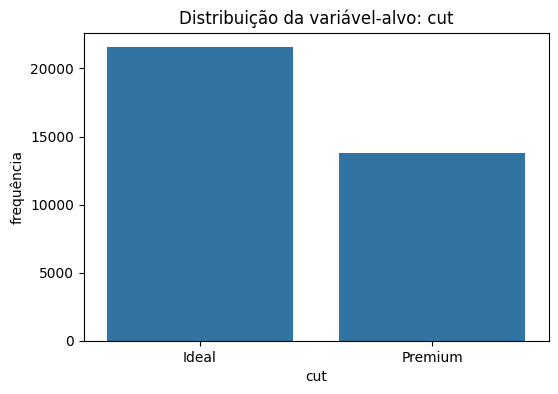

cut
Ideal      21551
Premium    13791
Name: count, dtype: int64


In [112]:
# distribuição da variável alvo cut

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="cut", data=df_clean, order=df_clean['cut'].value_counts().index)
plt.title("Distribuição da variável-alvo: cut")
plt.xlabel("cut")
plt.ylabel("frequência")
plt.show()

# também podemos inspecionar a contagem absoluta
print(df_clean['cut'].value_counts())

In [113]:
# recodificação da variável alvo cut

map_cut = {
    'Ideal': 0,
    'Premium': 1
}

df_model['cut_code'] = df_clean['cut'].map(map_cut).astype('int8')

# definir variável alvo y
y = df_model['cut_code']

print(df_model[['cut','cut_code']].head())
print(y.value_counts())

       cut  cut_code
0    Ideal         0
1  Premium         1
2  Premium         1
3    Ideal         0
4  Premium         1
cut_code
0    21551
1    13791
Name: count, dtype: int64


In [114]:
# separar X e y

X = df_model.drop(columns=['cut','cut_code'])
y = df_model['cut_code']

print("shape X:", X.shape)
print("shape y:", y.shape)

shape X: (35342, 22)
shape y: (35342,)


In [115]:
# escalonamento do conjunto de dados

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("shape após escalonamento:", X_scaled.shape)

shape após escalonamento: (35342, 22)


In [116]:
# separação em treino e teste

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("treino:", X_train.shape, y_train.shape)
print("teste:", X_test.shape, y_test.shape)

treino: (26506, 22) (26506,)
teste: (8836, 22) (8836,)


matriz de confusão:
 [[4834  554]
 [ 504 2944]]


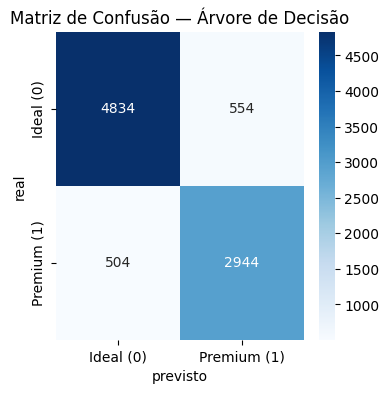

In [117]:
# q1 — árvore de decisão: matriz de confusão

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# treino do modelo
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# predição
y_pred_dt = dt.predict(X_test)

# matriz de confusão
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("matriz de confusão:\n", cm_dt)

# visualização
plt.figure(figsize=(4,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Ideal (0)", "Premium (1)"],
            yticklabels=["Ideal (0)", "Premium (1)"])
plt.xlabel("previsto")
plt.ylabel("real")
plt.title("Matriz de Confusão — Árvore de Decisão")
plt.show()

In [118]:
# q2 — árvore de decisão: relatório de classificação

from sklearn.metrics import classification_report

print("relatório de classificação — árvore de decisão:\n")
print(classification_report(y_test, y_pred_dt))

relatório de classificação — árvore de decisão:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5388
           1       0.84      0.85      0.85      3448

    accuracy                           0.88      8836
   macro avg       0.87      0.88      0.87      8836
weighted avg       0.88      0.88      0.88      8836



matriz de confusão — random forest:
[[5095  293]
 [ 396 3052]]


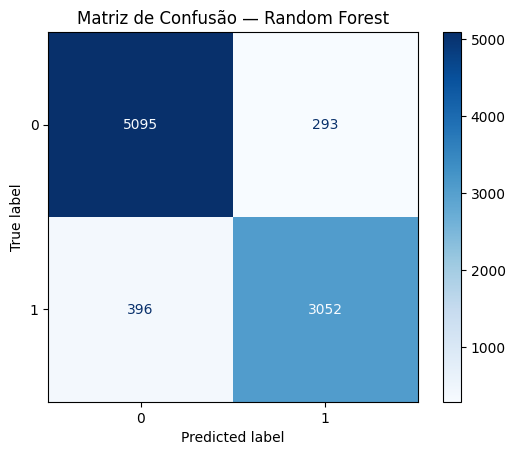


relatório de classificação — random forest:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5388
           1       0.91      0.89      0.90      3448

    accuracy                           0.92      8836
   macro avg       0.92      0.92      0.92      8836
weighted avg       0.92      0.92      0.92      8836



In [119]:
# q3 — random forest (default): matriz de confusão e relatório de classificação

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# treino do modelo random forest com parâmetros padrão
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# previsões
y_pred_rf = rf_clf.predict(X_test)

# matriz de confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("matriz de confusão — random forest:")
print(cm_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_clf.classes_)
disp_rf.plot(cmap="Blues")
plt.title("Matriz de Confusão — Random Forest")
plt.show()

# relatório de classificação
print("\nrelatório de classificação — random forest:\n")
print(classification_report(y_test, y_pred_rf))

In [120]:
# q4 — gridsearch random forest (3 parâmetros)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# grade com 3 hiperparâmetros
param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# gridsearch com acurácia e cv=5
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

# melhor combinação e score médio de cv
print("melhores parâmetros:", rf_grid.best_params_)
print("melhor accuracy (cv):", rf_grid.best_score_)

# treinar modelo final com melhor combinação e gerar predições do teste
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

melhores parâmetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
melhor accuracy (cv): 0.9211121137474969


matriz de confusão — rf (melhor grid):
[[5089  299]
 [ 407 3041]]


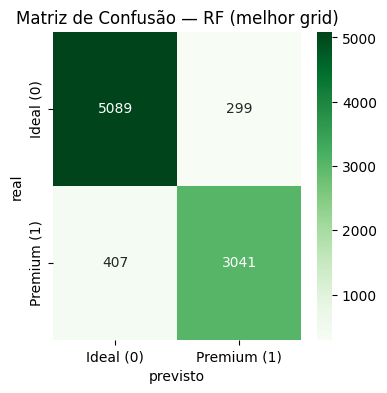


relatório de classificação — rf (melhor grid):

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      5388
           1       0.91      0.88      0.90      3448

    accuracy                           0.92      8836
   macro avg       0.92      0.91      0.92      8836
weighted avg       0.92      0.92      0.92      8836



In [121]:
# q5 — relatório do melhor random forest (grid)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# matriz de confusão
cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
print("matriz de confusão — rf (melhor grid):")
print(cm_rf_best)

# visualização
plt.figure(figsize=(4,4))
sns.heatmap(cm_rf_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Ideal (0)", "Premium (1)"],
            yticklabels=["Ideal (0)", "Premium (1)"])
plt.xlabel("previsto")
plt.ylabel("real")
plt.title("Matriz de Confusão — RF (melhor grid)")
plt.show()

# relatório de classificação
print("\nrelatório de classificação — rf (melhor grid):\n")
print(classification_report(y_test, y_pred_rf_best))

matriz de confusão — xgboost (default):
 [[5070  318]
 [ 406 3042]]


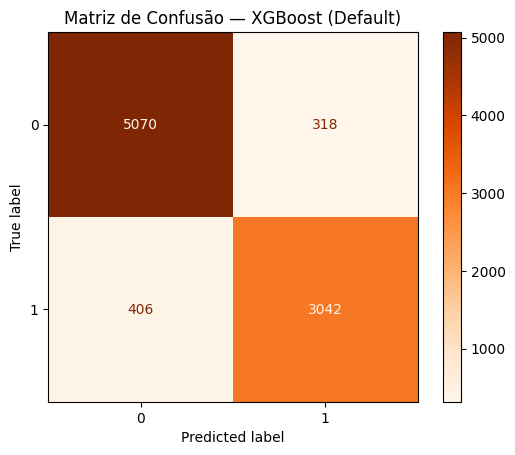


relatório de classificação — xgboost (default):

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5388
           1       0.91      0.88      0.89      3448

    accuracy                           0.92      8836
   macro avg       0.92      0.91      0.91      8836
weighted avg       0.92      0.92      0.92      8836



In [122]:
# q6 — xgboost (default): matriz de confusão e relatório

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# modelo xgboost com opções padrão (apenas eval_metric para evitar warning)
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

# treino
xgb.fit(X_train, y_train)

# predição
y_pred_xgb = xgb.predict(X_test)

# matriz de confusão
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("matriz de confusão — xgboost (default):\n", cm_xgb)

# visualização
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb.classes_)
disp.plot(cmap="Oranges")
plt.title("Matriz de Confusão — XGBoost (Default)")
plt.show()

# relatório de classificação
print("\nrelatório de classificação — xgboost (default):\n")
print(classification_report(y_test, y_pred_xgb))

matriz de confusão — svm (default):
 [[5068  320]
 [ 443 3005]]


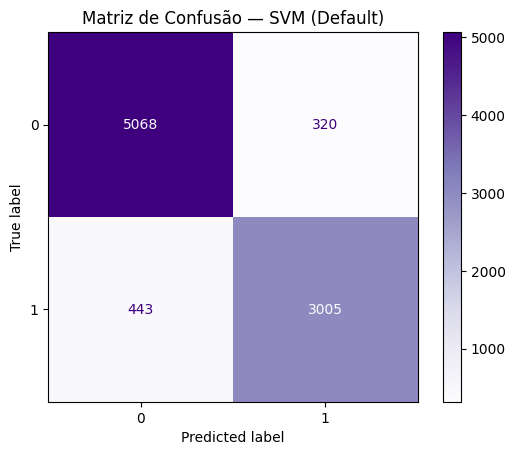


relatório de classificação — svm (default):

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5388
           1       0.90      0.87      0.89      3448

    accuracy                           0.91      8836
   macro avg       0.91      0.91      0.91      8836
weighted avg       0.91      0.91      0.91      8836



In [123]:
# q7 — svm (default): matriz de confusão e relatório

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# modelo SVM com configuração padrão
svm = SVC(random_state=42)

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("matriz de confusão — svm (default):\n", cm_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)
disp.plot(cmap="Purples")
plt.title("Matriz de Confusão — SVM (Default)")
plt.show()

# relatório de classificação
print("\nrelatório de classificação — svm (default):\n")
print(classification_report(y_test, y_pred_svm))

In [124]:
# q8 — gridsearch para svm

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# definir parâmetros para grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print("melhores parâmetros:", svm_grid.best_params_)
print("melhor accuracy (cv):", svm_grid.best_score_)

# gerar previsões no teste com o melhor modelo
svm_best = svm_grid.best_estimator_
y_pred_svm_best = svm_best.predict(X_test)

melhores parâmetros: {'C': 0.1, 'kernel': 'linear'}
melhor accuracy (cv): 0.9179053210959036


matriz de confusão — svm (melhor grid):
 [[5073  315]
 [ 417 3031]]


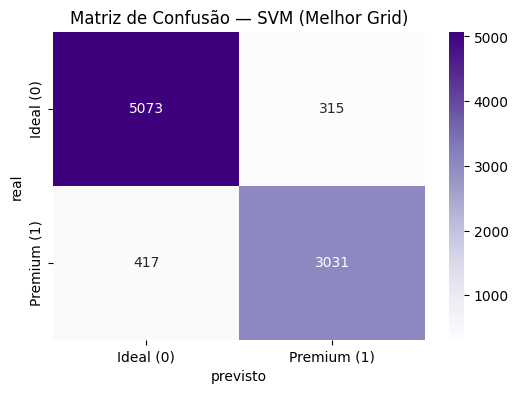

In [125]:
# q9 — svm (melhor grid): matriz de confusão e relatório de classificação

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# matriz de confusão
cm = confusion_matrix(y_test, y_pred_svm_best)
print("matriz de confusão — svm (melhor grid):\n", cm)

# heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Ideal (0)", "Premium (1)"],
            yticklabels=["Ideal (0)", "Premium (1)"])
plt.xlabel("previsto")
plt.ylabel("real")
plt.title("Matriz de Confusão — SVM (Melhor Grid)")
plt.show()

In [126]:
# q10 — relatório de classificação do svm com melhor configuração

from sklearn.metrics import classification_report

# opcional: deixar explícita a melhor combinação encontrada na q8
print("melhor combinação (svm):", svm_grid.best_params_)

# relatório no conjunto de testes, reaproveitando as predições da q9
print("\nrelatório de classificação — svm (melhor grid):\n")
print(classification_report(y_test, y_pred_svm_best))

melhor combinação (svm): {'C': 0.1, 'kernel': 'linear'}

relatório de classificação — svm (melhor grid):

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5388
           1       0.91      0.88      0.89      3448

    accuracy                           0.92      8836
   macro avg       0.91      0.91      0.91      8836
weighted avg       0.92      0.92      0.92      8836



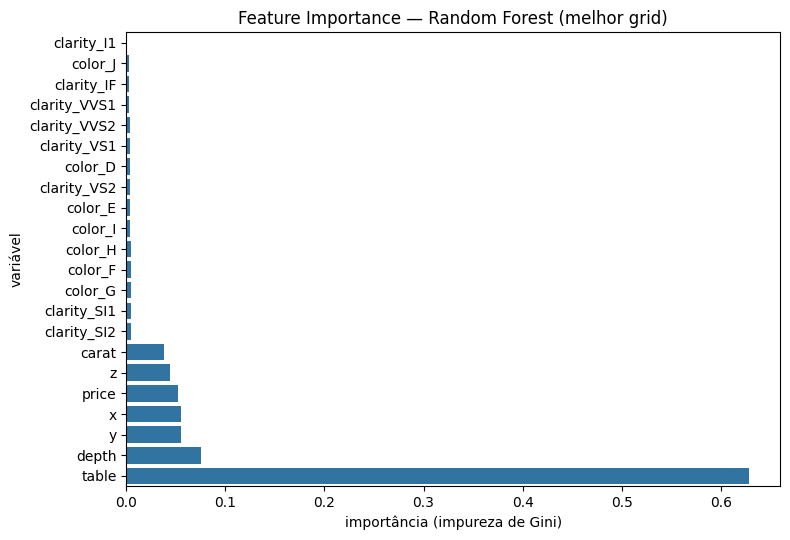

,feature,importance
0,table,0.628502
1,depth,0.075568
2,y,0.055033
3,x,0.054836
4,price,0.052435
5,z,0.043724
6,carat,0.037694
7,clarity_SI2,0.004872
8,clarity_SI1,0.004729
9,color_G,0.004488


In [127]:
# q11 — feature importance do melhor random forest (visualização)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# nomes das colunas (antes do escalonamento)
feature_names = list(X.columns)

# importâncias do melhor RF (rf_best criado na Q4)
importances = rf_best.feature_importances_

# série ordenada (crescente para plot horizontal)
fi = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# gráfico
plt.figure(figsize=(8, max(4, len(fi)*0.25)))
sns.barplot(x=fi.values, y=fi.index, orient='h')
plt.xlabel("importância (impureza de Gini)")
plt.ylabel("variável")
plt.title("Feature Importance — Random Forest (melhor grid)")
plt.tight_layout()
plt.show()

# guardar para a q12
fi_df = fi.sort_values(ascending=False).reset_index()
fi_df.columns = ["feature", "importance"]
fi_df.head(10)

In [128]:
# q12 — top 3 variáveis mais relevantes no random forest (melhor grid)

# ordenar importâncias
top3_features = fi_df.sort_values(by="importance", ascending=False).head(3)

print("Top 3 variáveis mais relevantes:\n")
print(top3_features)

Top 3 variáveis mais relevantes:

  feature  importance
0   table    0.628502
1   depth    0.075568
2       y    0.055033


interpretação

as três variáveis mais relevantes identificadas pelo modelo Random Forest (melhor configuração via GridSearch) foram:
- table — disparadamente a mais importante, com peso muito superior às demais.
- depth — segunda mais relevante, relacionada à proporção da pedra.
- y — dimensão física que também contribuiu fortemente.

isso indica que o modelo se apoia majoritariamente na variável table, mas também leva em conta medidas geométricas ligadas às dimensões do diamante para classificar entre Ideal (0) e Premium (1).

In [129]:
# q13 — lime em duas observações do conjunto de teste (rf_best)

import lime
import lime.lime_tabular
import numpy as np

# inicializar explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=["Ideal (0)", "Premium (1)"],
    mode="classification"
)

# escolher 2 observações do teste
sample_idxs = [0, 1]

for idx in sample_idxs:
    print(f"\n--- explicação para observação {idx} ---\n")
    exp = explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=rf_best.predict_proba,
        num_features=5
    )
    exp.show_in_notebook(show_table=True)


--- explicação para observação 0 ---




--- explicação para observação 1 ---



q14 — interpretação com lime

foram analisadas duas observações do conjunto de teste usando a técnica lime.

observação 0:
- predição: classe *ideal (0)*, com probabilidade de 96%.
- principais fatores que contribuíram para a decisão:
  - table teve impacto negativo forte, puxando para a classe *ideal*.
  - clarity_si2 também reduziu a chance de ser *premium*.
  - variáveis x, y e carat tiveram contribuições menores.

interpretação: a variável table foi determinante para a classificação como *ideal*, em linha com o resultado de importância de variáveis no random forest (questões 11/12).

observação 1:
- predição: classe *ideal (0)*, com probabilidade de 99%.
- principais fatores que contribuíram para a decisão:
  - table novamente teve forte impacto negativo, puxando para *ideal*.
  - x e y reforçaram a classificação como *ideal*.
  - carat e price também influenciaram, mas em menor magnitude.

interpretação: assim como na primeira observação, a variável table dominou a decisão. variáveis geométricas como x e y reforçaram a classificação, confirmando que o modelo prioriza medidas geométricas mais do que variáveis categóricas.

ou seja, o lime confirmou o papel dominante de table e mostrou que variáveis geométricas (x, y, carat) têm grande peso nas predições.